In [2]:
import numpy as np
import pandas as pd
import _pickle as cPickle
import os
import torch
import seaborn as sns

from game import TinyHintGuessGame
from agent import QAgent

In [3]:
# append results to list

model_name = 'ActionIn-one_hot-4-20-3'

res_list = []
for res_folder in sorted(list(os.walk('../res'))[0][1]):
    if res_folder.startswith(model_name):
        try:
            with open(f'../res/{res_folder}/2000000.pkl', 'rb') as fp: 
                res = cPickle.load(fp)
                res_list.append(res)
        except FileNotFoundError:
                print(f"no pickle found for {res_folder}!")
print(f'file loaded! model count: {len(res_list)}')

file loaded! model count: 15


In [4]:
res_list = res_list[:15]

In [5]:
def sample_games(hinter, guesser, samples=100, print_games=False, env=None):
    r_list = []
    if not env:
        env = hinter.env
    for _ in range(samples):
        obs_to_hinter = env.reset()
        hint_action = hinter.select_action(torch.tensor(obs_to_hinter, device=hinter.device))
        obs_to_guesser, _, _, _ = env.step(hint_action.item())
        guess_action = guesser.select_action(torch.tensor(obs_to_guesser, device=hinter.device))
        _, r, _, _ = env.step(guess_action)
        r_list += [r]
        if print_games:
            print(env.h1, env.h2, "target:", env.target, "hint", env.hint, "guess", env.guess, r)
    r_list = np.array(r_list)
    return np.sum(np.array(r_list) >= 0, axis=0) / r_list.shape[0]
    
def cross_play(res_list, samples=100):
    group_size = len(res_list)
    score_array = np.zeros((group_size, group_size))
    for i in range(group_size):
        for j in range(group_size):
            p1 = res_list[i]['p1']
            p2 = res_list[j]['p2']
            score_array[i][j] = sample_games(p1, p2, samples = samples)
            print(i, j, "score:", score_array[i][j])
    return score_array

In [ ]:
# %%time
score_array = cross_play(res_list, samples=100)

0 0 score: 0.57
0 1 score: 0.42
0 2 score: 0.39
0 3 score: 0.35
0 4 score: 0.3
0 5 score: 0.4
0 6 score: 0.41
0 7 score: 0.35
0 8 score: 0.37
0 9 score: 0.35
0 10 score: 0.31
0 11 score: 0.43
0 12 score: 0.36
0 13 score: 0.38
0 14 score: 0.35
1 0 score: 0.32
1 1 score: 0.68
1 2 score: 0.41
1 3 score: 0.48
1 4 score: 0.38
1 5 score: 0.38
1 6 score: 0.42
1 7 score: 0.41
1 8 score: 0.42
1 9 score: 0.3
1 10 score: 0.45
1 11 score: 0.39
1 12 score: 0.45
1 13 score: 0.35
1 14 score: 0.38
2 0 score: 0.44
2 1 score: 0.38
2 2 score: 0.62
2 3 score: 0.4
2 4 score: 0.37
2 5 score: 0.43
2 6 score: 0.33
2 7 score: 0.4
2 8 score: 0.43
2 9 score: 0.26
2 10 score: 0.43
2 11 score: 0.46
2 12 score: 0.37
2 13 score: 0.34
2 14 score: 0.38
3 0 score: 0.38
3 1 score: 0.33
3 2 score: 0.33
3 3 score: 0.69
3 4 score: 0.41
3 5 score: 0.34
3 6 score: 0.4
3 7 score: 0.37
3 8 score: 0.4
3 9 score: 0.38
3 10 score: 0.31
3 11 score: 0.34
3 12 score: 0.35
3 13 score: 0.36
3 14 score: 0.43
4 0 score: 0.39
4 1 score: 

In [1]:
np.savetxt(f"../{model_name}.csv", score_array, delimiter=",")

NameError: name 'np' is not defined

In [45]:
print('sp', np.diagonal(score_array).mean(), 'sde', np.diagonal(score_array).std() / np.sqrt(score_array.shape[0]) )

sp 0.6386666666666667 sde 0.0129569086390806


In [46]:
off_diag_scores = np.ma.array(score_array, mask=False)
off_diag_scores.mask[np.diag_indices(score_array.shape[0])] = True
print('xp', off_diag_scores.mean(), 'sde', off_diag_scores.std() / np.sqrt(off_diag_scores.shape[0] * (off_diag_scores.shape[0]-1) ))

xp 0.36676190476190473 sde 0.0035825164240100116


<AxesSubplot:>

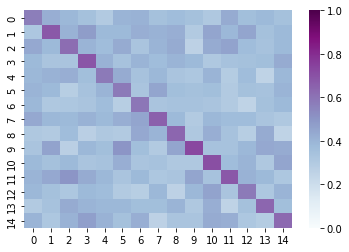

In [47]:
sns.heatmap(score_array, cmap="BuPu", vmin=0, vmax=1)

In [51]:
sample_games(res_list[1]['p1'], res_list[1]['p2'], samples=20, print_games=True)

[0 5 5] [1 4 2] target: 1 hint 5 guess 2 -10.0
[ 0 12  1] [16 17 10] target: 17 hint 1 guess 17 10.0
[ 4  7 17] [14 11  3] target: 11 hint 4 guess 11 10.0
[ 2  2 10] [ 6 19 11] target: 19 hint 10 guess 6 -10.0
[ 4 12  7] [ 1 16 12] target: 1 hint 12 guess 1 10.0
[13  3  7] [17  7 13] target: 17 hint 13 guess 17 10.0
[19  0 18] [ 3  7 14] target: 7 hint 18 guess 3 -10.0
[ 3 16 15] [16  1  6] target: 6 hint 16 guess 6 10.0
[13  1 13] [13 11  8] target: 11 hint 13 guess 11 10.0
[ 2  3 19] [11  7  7] target: 7 hint 2 guess 7 10.0
[ 2  8 14] [ 1 13 17] target: 17 hint 14 guess 17 10.0
[ 6 13 11] [ 2  4 14] target: 4 hint 6 guess 2 -10.0
[19  6 19] [12 17  0] target: 17 hint 19 guess 17 10.0
[19 15  7] [14 15 13] target: 14 hint 15 guess 14 10.0
[ 3 15  3] [17  5  0] target: 17 hint 15 guess 0 -10.0
[8 5 4] [10  3  9] target: 10 hint 8 guess 3 -10.0
[13 11 19] [12 10  6] target: 12 hint 13 guess 12 10.0
[9 4 3] [18 19 14] target: 14 hint 3 guess 18 -10.0
[11  8 10] [16 18 15] target: 16 hint

0.55